In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from reusable_modules.metrics import MSE, MAE, RMSE, R2_Score
from reusable_modules.gd_poly import compute_cost, gradient_descent
from reusable_modules.constants import (
   learning_rates , iteration_counts ,  degrees
) 


In [3]:
df = pd.read_csv('data/zuu crew scores.csv')
df = df[df['CourseName'] == 'Foundations of ML']
df.head(5)

,MemberName,EducationLevel,Attendance,TotalHours,AssignmentsCompleted,HackathonParticipation,GitHubScore,PeerReviewScore,CourseName,CapstoneScore
0,Theekshana Rathnayake,3,79.9,43.7,2,0,62.8,5.0,Foundations of ML,45.3
1,Mayura Sandakalum Sellapperuma,2,76.8,95.6,6,0,87.4,2.7,Foundations of ML,78.8
2,Amila Narangoda,3,96.6,75.9,8,0,98.4,2.8,Foundations of ML,65.4
4,Tharusha Vihanga,2,83.2,24.0,6,0,41.8,4.2,Foundations of ML,40.1
7,Chamath Perera,3,86.5,88.0,5,0,23.9,1.3,Foundations of ML,68.2


In [4]:
X_raw = df['TotalHours'].values.reshape(-1)
y = df['CapstoneScore'].values


In [5]:
def train_test_split_np(X, y, test_size=0.2, seed=42):
    rng = np.random.default_rng(seed)
    m = X.shape[0]
    idx = np.arange(m)
    rng.shuffle(idx)
    m_test = int(np.round(m * test_size))
    test_idx = idx[:m_test]
    train_idx = idx[m_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train_raw, X_test_raw, y_train, y_test = train_test_split_np(X_raw, y, test_size=0.2, seed=42)

In [6]:
mu, sd = X_train_raw.mean(), X_train_raw.std() + 1e-12
X_train = (X_train_raw - mu) / sd
X_test  = (X_test_raw  - mu) / sd

In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)

X_train shape: (58,)
y_train shape: (58,)
X_test  shape: (14,)
y_test  shape: (14,)


In [8]:

def create_polynomial_features(X, degree):

    m = len(X)
    X_poly = np.ones((m, degree + 1), dtype=float)   # explicit dtype
    for d in range(1, degree + 1):
        X_poly[:, d] = X ** d
    return X_poly

In [9]:
ITERATIONS = 10000
def fit_polynomial(X, y, degree, learning_rate):
    X_poly = create_polynomial_features(X, degree)
    beta_init = np.zeros(X_poly.shape[1], dtype=float)
    cost_history, beta = gradient_descent(
        X_poly, y, beta_init, lr=learning_rate, n_iter=ITERATIONS
    )
    return beta, cost_history

In [10]:
def predict_polynomial(X, beta):
    x = np.asarray(X, dtype=float)      
    degree = len(beta) - 1
    X_poly = create_polynomial_features(x, degree)
    return np.dot(X_poly, beta) 

In [12]:
results = {}   
rows = []      

for deg in degrees:
    for lr in learning_rates:
        for n_iter in iteration_counts:
            ITERATIONS = n_iter  # set the knob here

            # ---- fit on TRAIN ONLY ----
            beta, cost_history = fit_polynomial(X_train, y_train, degree=deg, learning_rate=lr)

            # ---- evaluate on both splits ----
            yhat_train = predict_polynomial(X_train, beta)
            yhat_test  = predict_polynomial(X_test,  beta)

            results[(deg, lr, n_iter)] = {
                "beta": beta,
                "cost_history": cost_history
            }

            rows.append({
                "Degree": deg, "α": lr, "Iterations": n_iter,
                "Final Cost (Train)": cost_history[-1],
        # Train metrics
        "Train MSE":  round(MSE(y_train, yhat_train), 6),
        "Train MAE":  round(MAE(y_train, yhat_train), 6),
        "Train RMSE": round(RMSE(y_train, yhat_train), 6),
        "Train R²":   round(R2_Score(y_train, yhat_train), 6),

        # Test metrics
        "Test MSE":   round(MSE(y_test, yhat_test), 6),
        "Test MAE":   round(MAE(y_test, yhat_test), 6),
        "Test RMSE":  round(RMSE(y_test, yhat_test), 6),
        "Test R²":    round(R2_Score(y_test, yhat_test), 6),
    })
           

summary_df = (
    pd.DataFrame(rows)
      .sort_values(by=["Test RMSE", "Final Cost (Train)"], ascending=[True, True])
      .reset_index(drop=True)
)
summary_df

Iteration : 0: Cost : 1687.5114
Iteration : 100: Cost : 1684.1606
Iteration : 200: Cost : 1680.8166
Iteration : 300: Cost : 1677.4792
Iteration : 400: Cost : 1674.1485
Iteration : 500: Cost : 1670.8245
Iteration : 600: Cost : 1667.5071
Iteration : 700: Cost : 1664.1963
Iteration : 800: Cost : 1660.8922
Iteration : 900: Cost : 1657.5946
Iteration : 0: Cost : 1687.5114
Iteration : 100: Cost : 1684.1606
Iteration : 200: Cost : 1680.8166
Iteration : 300: Cost : 1677.4792
Iteration : 400: Cost : 1674.1485
Iteration : 500: Cost : 1670.8245
Iteration : 600: Cost : 1667.5071
Iteration : 700: Cost : 1664.1963
Iteration : 800: Cost : 1660.8922
Iteration : 900: Cost : 1657.5946
Iteration : 1000: Cost : 1654.3036
Iteration : 1100: Cost : 1651.0192
Iteration : 1200: Cost : 1647.7414
Iteration : 1300: Cost : 1644.4701
Iteration : 1400: Cost : 1641.2054
Iteration : 1500: Cost : 1637.9472
Iteration : 1600: Cost : 1634.6955
Iteration : 1700: Cost : 1631.4502
Iteration : 1800: Cost : 1628.2115
Iteration

Iteration : 4400: Cost : 1546.2385
Iteration : 4500: Cost : 1543.1700
Iteration : 4600: Cost : 1540.1077
Iteration : 4700: Cost : 1537.0514
Iteration : 4800: Cost : 1534.0013
Iteration : 4900: Cost : 1530.9573
Iteration : 0: Cost : 1687.5114
Iteration : 100: Cost : 1684.1606
Iteration : 200: Cost : 1680.8166
Iteration : 300: Cost : 1677.4792
Iteration : 400: Cost : 1674.1485
Iteration : 500: Cost : 1670.8245
Iteration : 600: Cost : 1667.5071
Iteration : 700: Cost : 1664.1963
Iteration : 800: Cost : 1660.8922
Iteration : 900: Cost : 1657.5946
Iteration : 1000: Cost : 1654.3036
Iteration : 1100: Cost : 1651.0192
Iteration : 1200: Cost : 1647.7414
Iteration : 1300: Cost : 1644.4701
Iteration : 1400: Cost : 1641.2054
Iteration : 1500: Cost : 1637.9472
Iteration : 1600: Cost : 1634.6955
Iteration : 1700: Cost : 1631.4502
Iteration : 1800: Cost : 1628.2115
Iteration : 1900: Cost : 1624.9793
Iteration : 2000: Cost : 1621.7534
Iteration : 2100: Cost : 1618.5341
Iteration : 2200: Cost : 1615.32

c:\Users\User\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
e:\IIT lectures\Zuu Crew\mini_project_00\reusable_modules\gd_poly.py:6: RuntimeWarning: overflow encountered in square
  cost = (1 / (2 * m)) * np.sum((y_hat - Y) ** 2)
e:\IIT lectures\Zuu Crew\mini_project_00\reusable_modules\metrics.py:10: RuntimeWarning: overflow encountered in square
  return np.mean(e_i ** 2)
e:\IIT lectures\Zuu Crew\mini_project_00\reusable_modules\metrics.py:29: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean(e_i ** 2))
e:\IIT lectures\Zuu Crew\mini_project_00\reusable_modules\metrics.py:45: RuntimeWarning: overflow encountered in square
  return 1 - (np.sum(e_i ** 2) / np.sum(std_i ** 2))
e:\IIT lectures\Zuu Crew\mini_project_00\reusable_modules\gd_poly.py:17: RuntimeWarning: invalid value encountered in subtract
  beta = beta - lr * gradients


Iteration : 6700: Cost : nan
Iteration : 6800: Cost : nan
Iteration : 6900: Cost : nan
Iteration : 7000: Cost : nan
Iteration : 7100: Cost : nan
Iteration : 7200: Cost : nan
Iteration : 7300: Cost : nan
Iteration : 7400: Cost : nan
Iteration : 7500: Cost : nan
Iteration : 7600: Cost : nan
Iteration : 7700: Cost : nan
Iteration : 7800: Cost : nan
Iteration : 7900: Cost : nan
Iteration : 8000: Cost : nan
Iteration : 8100: Cost : nan
Iteration : 8200: Cost : nan
Iteration : 8300: Cost : nan
Iteration : 8400: Cost : nan
Iteration : 8500: Cost : nan
Iteration : 8600: Cost : nan
Iteration : 8700: Cost : nan
Iteration : 8800: Cost : nan
Iteration : 8900: Cost : nan
Iteration : 9000: Cost : nan
Iteration : 9100: Cost : nan
Iteration : 9200: Cost : nan
Iteration : 9300: Cost : nan
Iteration : 9400: Cost : nan
Iteration : 9500: Cost : nan
Iteration : 9600: Cost : nan
Iteration : 9700: Cost : nan
Iteration : 9800: Cost : nan
Iteration : 9900: Cost : nan
Iteration : 0: Cost : 1687.4705
Iteration :

,Degree,α,Iterations,Final Cost (Train),Train MSE,Train MAE,Train RMSE,Train R²,Test MSE,Test MAE,Test RMSE,Test R²
0,1,0.10000,1000,10.473364,20.946728,3.689859e+00,4.576760,0.927012,41.289453,4.975695e+00,6.425687,0.850377
1,1,0.10000,5000,10.473364,20.946728,3.689859e+00,4.576760,0.927012,41.289453,4.975695e+00,6.425687,0.850377
2,1,0.10000,10000,10.473364,20.946728,3.689859e+00,4.576760,0.927012,41.289453,4.975695e+00,6.425687,0.850377
3,1,1.00000,1000,10.473364,20.946728,3.689859e+00,4.576760,0.927012,41.289453,4.975695e+00,6.425687,0.850377
4,1,1.00000,5000,10.473364,20.946728,3.689859e+00,4.576760,0.927012,41.289453,4.975695e+00,6.425687,0.850377
5,1,1.00000,10000,10.473364,20.946728,3.689859e+00,4.576760,0.927012,41.289453,4.975695e+00,6.425687,0.850377
6,1,0.00100,10000,10.473367,20.946735,3.690203e+00,4.576760,0.927012,41.291416,4.975644e+00,6.425840,0.850370
7,1,0.00100,5000,10.549123,21.098246,3.750675e+00,4.593283,0.926484,41.717135,4.968225e+00,6.458880,0.848827
8,2,0.10000,1000,10.067857,20.135713,3.582042e+00,4.487284,0.929838,42.300141,4.869606e+00,6.503856,0.846714
9,2,0.10000,5000,10.067857,20.135713,3.582042e+00,4.487284,0.929838,42.300141,4.869606e+00,6.503856,0.846714


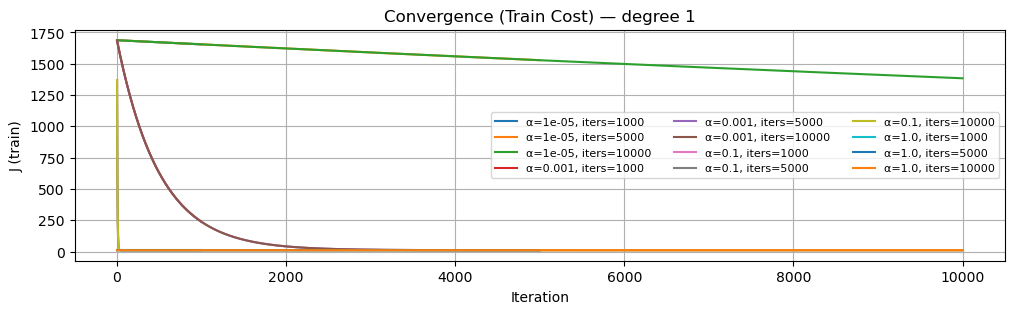

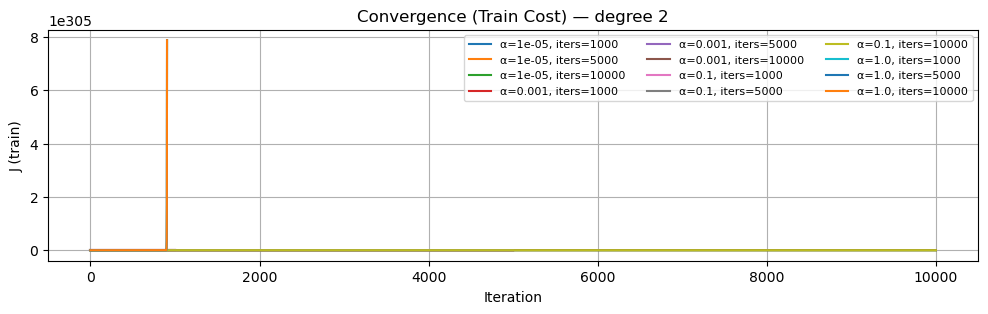

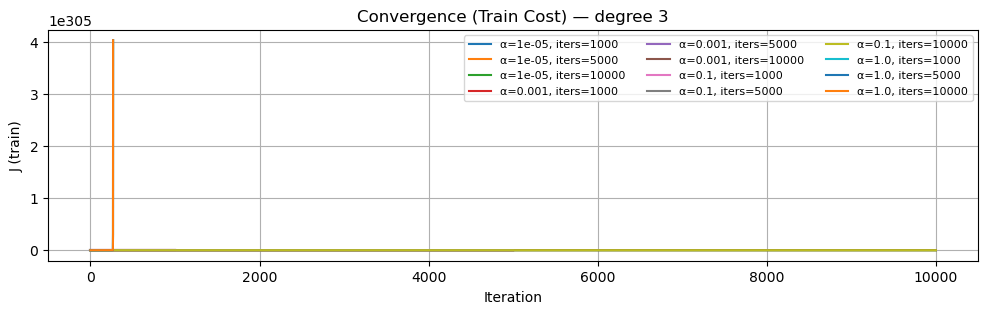

In [13]:
for deg in degrees:
    plt.figure(figsize=(12,3))
    for lr in learning_rates:
        for n_iter in iteration_counts:
            ch = results[(deg, lr, n_iter)]["cost_history"]
            plt.plot(ch, label=f"α={lr}, iters={n_iter}")
    plt.title(f"Convergence (Train Cost) — degree {deg}")
    plt.xlabel("Iteration"); plt.ylabel("J (train)"); plt.grid(True)
    plt.legend(ncol=3, fontsize=8)
    plt.show()

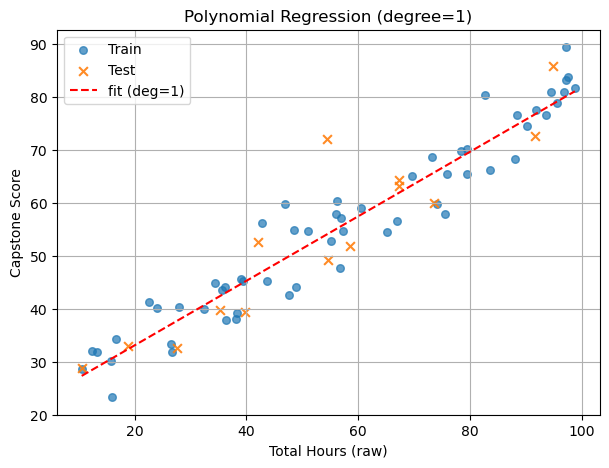

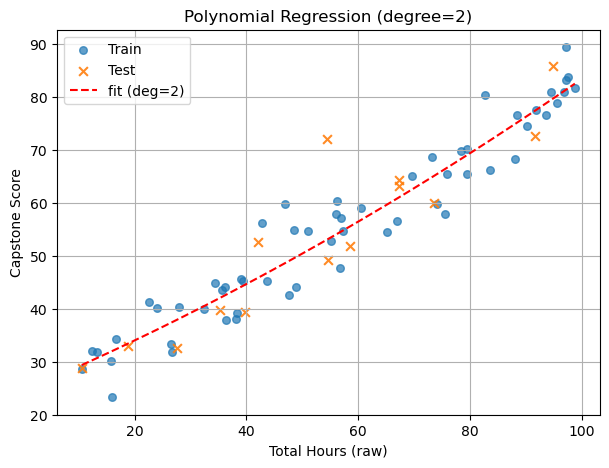

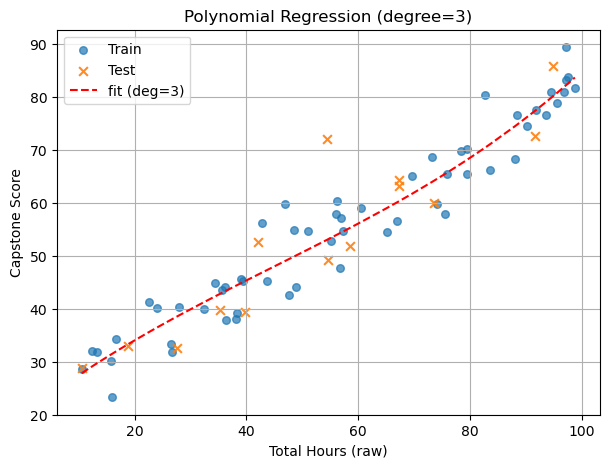

In [14]:
def plot_fit_raw_axis(degree, beta):
    # Build a smooth line over RAW hours (but predict on standardized)
    X_all_raw = np.r_[X_train_raw, X_test_raw]
    order = np.argsort(X_all_raw)
    X_all_raw_sorted = X_all_raw[order]
    X_all_std_sorted = (X_all_raw_sorted - mu) / sd
    y_line = predict_polynomial(X_all_std_sorted, beta)

    plt.figure(figsize=(7,5))
    plt.scatter(X_train_raw, y_train, alpha=0.7, s=30, label="Train")
    plt.scatter(X_test_raw,  y_test,  alpha=0.9, s=40, marker="x", label="Test")
    plt.plot(X_all_raw_sorted, y_line, 'r--', label=f"fit (deg={degree})")
    plt.xlabel("Total Hours (raw)"); plt.ylabel("Capstone Score")
    plt.title(f"Polynomial Regression (degree={degree})")
    plt.grid(True); plt.legend(); plt.show()

# Show best per degree by lowest Test RMSE
for deg in degrees:
    sub = summary_df[summary_df["Degree"] == deg]
    best = sub.iloc[0]
    beta_best = results[(deg, best["α"], best["Iterations"])]["beta"]
    plot_fit_raw_axis(deg, beta_best)
